In [6]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

class Backtester:
    def __init__(self, symbol, start, end, initial_capital=100000):
        self.symbol = symbol
        self.start = start
        self.end = end
        self.initial_capital = initial_capital

        # Will be populated later
        self.data = None        # raw OHLCV + indicators + signals
        self.trades = None      # DataFrame of individual trades
        self.results = None     # portfolio equity curve, cash, holdings
        self.metrics = {}       # computed performance metrics

    def fetch_data(self):
        self.data = yf.download(self.symbol,
                                start=self.start,
                                end=self.end,
                                progress=False).dropna()
        
        # Flatten MultiIndex columns if they exist
        if isinstance(self.data.columns, pd.MultiIndex):
            self.data.columns = self.data.columns.droplevel(1)

    def generate_sma_signals(self, short_window=20, long_window=50):
        df = self.data.copy()
        df['SMA_short'] = df['Close'].rolling(short_window).mean()
        df['SMA_long']  = df['Close'].rolling(long_window).mean()
        df['signal']    = 0
        
        # Use boolean indexing instead of integer slicing with .loc
        valid_mask = ~(df['SMA_short'].isna() | df['SMA_long'].isna())
        df.loc[valid_mask, 'signal'] = (
            df.loc[valid_mask, 'SMA_short'] > df.loc[valid_mask, 'SMA_long']
        ).astype(int)
        
        df['positions'] = df['signal'].diff().fillna(0)
        self.data = df

    def backtest(self):
        df = self.data.copy()
        
        # Calculate number of shares we can buy with all our money
        # When signal=1, we're all-in; when signal=0, we're in cash
        shares_when_long = self.initial_capital / df['Close'].iloc[0]  # Fixed number of shares
        
        # holdings: dollar value of our stock position
        df['holdings'] = df['signal'] * shares_when_long * df['Close']
        
        # cash: what's left after accounting for our stock position
        df['cash'] = self.initial_capital - df['holdings']
        
        # total equity
        df['total'] = df['cash'] + df['holdings']
        
        # daily returns
        df['returns'] = df['total'].pct_change().fillna(0)

        self.results = df
        self._generate_trades()
        self._compute_metrics()

    def _generate_trades(self):
        """
        Build a DataFrame of individual trades with:
         entry_date, exit_date, entry_price, exit_price, pnl, return_pct
        """
        trades = []
        in_trade = False
        entry_price = entry_date = None

        for dt, row in self.results.iterrows():
            pos = row['positions']
            price = row['Close']
            if pos == 1:  # enter long
                in_trade = True
                entry_price = price
                entry_date = dt
            elif pos == -1 and in_trade:  # exit long
                exit_price = price
                exit_date = dt
                pnl = exit_price - entry_price
                return_pct = pnl / entry_price
                trades.append({
                    'entry_date': entry_date,
                    'exit_date': exit_date,
                    'entry_price': entry_price,
                    'exit_price': exit_price,
                    'pnl': pnl,
                    'return_pct': return_pct
                })
                in_trade = False

        self.trades = pd.DataFrame(trades)

    def _compute_metrics(self):
        df = self.results
        total_return = df['total'].iloc[-1] / self.initial_capital - 1
        days = (df.index[-1] - df.index[0]).days
        cagr = (1 + total_return) ** (365.0/days) - 1

        # Sharpe (assume risk-free ~0, trading days=252)
        daily_ret = df['returns']
        sharpe = np.sqrt(252) * daily_ret.mean() / daily_ret.std()

        # Max Drawdown
        cum_max = df['total'].cummax()
        drawdown = (df['total'] - cum_max) / cum_max
        max_dd = drawdown.min()

        # Trade metrics
        num_trades = len(self.trades)
        wins = self.trades[self.trades['pnl'] > 0]
        win_rate = len(wins) / num_trades if num_trades>0 else np.nan
        avg_win = wins['pnl'].mean() if len(wins)>0 else np.nan
        avg_loss = self.trades[self.trades['pnl'] <= 0]['pnl'].mean() if num_trades>0 else np.nan
        expectancy = (win_rate * avg_win + (1-win_rate) * avg_loss) if num_trades>0 else np.nan

        self.metrics = {
            'Total Return (%)': total_return*100,
            'CAGR (%)': cagr*100,
            'Sharpe Ratio': sharpe,
            'Max Drawdown (%)': max_dd*100,
            'Number of Trades': num_trades,
            'Win Rate (%)': win_rate*100,
            'Avg Win': avg_win,
            'Avg Loss': avg_loss,
            'Expectancy': expectancy
        }

    def print_metrics(self):
        if not self.metrics:
            raise ValueError("Run backtest() first to compute metrics.")
        print(f"\nPerformance Metrics for {self.symbol} ({self.start} to {self.end}):\n" + "-"*60)
        for k, v in self.metrics.items():
            # format percentages nicely
            if '(%' in k:
                print(f"{k:20s}: {v:8.2f}%")
            else:
                print(f"{k:20s}: {v:8.4f}")
        print("-"*60)

    def plot_equity_curve(self):
        if self.results is None:
            raise ValueError("Run backtest() before plotting.")
        plt.figure()
        plt.plot(self.results.index, self.results['total'])
        plt.title(f'Equity Curve: {self.symbol}')
        plt.xlabel('Date')
        plt.ylabel('Portfolio Value')
        plt.show()



Performance Metrics for AAPL (2020-01-01 to 2021-01-01):
------------------------------------------------------------
Total Return (%)    :     0.00%
CAGR (%)            :     0.00%
Sharpe Ratio        :      nan
Max Drawdown (%)    :     0.00%
Number of Trades    :   1.0000
Win Rate (%)        :   100.00%
Avg Win             :  38.8556
Avg Loss            :      nan
Expectancy          :      nan
------------------------------------------------------------


/var/folders/mn/tx231v5158797chnp22wm9000000gp/T/ipykernel_49209/2855405704.py:20: FutureWarning: YF.download() has changed argument auto_adjust default to True
  self.data = yf.download(self.symbol,
/var/folders/mn/tx231v5158797chnp22wm9000000gp/T/ipykernel_49209/2855405704.py:108: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = np.sqrt(252) * daily_ret.mean() / daily_ret.std()


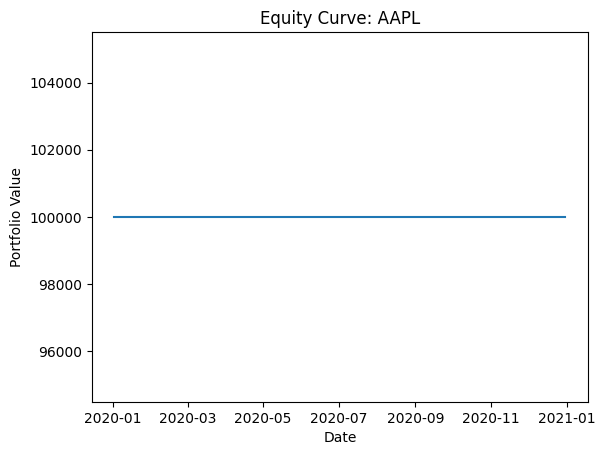

  entry_date  exit_date  entry_price  exit_price        pnl  return_pct
0 2020-04-30 2020-10-02    71.205719  110.061333  38.855614    0.545681


In [7]:
bt = Backtester('AAPL', '2020-01-01', '2021-01-01', initial_capital=100000)
bt.fetch_data()
bt.generate_sma_signals(short_window=20, long_window=50)
bt.backtest()
bt.print_metrics()
bt.plot_equity_curve()

# Optional: inspect trade log
print(bt.trades.head())
